In [257]:
using SpectralUnmixing
using Plots
using Statistics




In [243]:
using DataFrames
using CSV
using Interpolations
using Logging
using Statistics
using Plots
using ModularIndices
using NMF
using MultivariateStats
using Clustering

function save_data(library::SpectralLibrary, output_filename::String; class_label_name::String = "Label")

    df = DataFrame()
    insertcols!(df, 1, class_label_name => library.classes)
    for (_wv, wv) in enumerate(library.wavelengths)
        insertcols!(df, 1 + _wv, string(wv) => library.spectra[:,_wv])
    end
    CSV.write(output_filename, df)

end

# Function to set NaNs to 0 in the spectra
function set_nans_to_zero!(library::SpectralLibrary)
    nan_indices = isnan.(library.spectra)
    library.spectra[nan_indices] .= 0
end


set_nans_to_zero! (generic function with 1 method)

In [268]:
base_library = SpectralLibrary("convex_hull__n_dims_4_unmix_library_modified.csv", "level_1", 8, 0, ["soil","npv","pv"])
water_library = SpectralLibrary("emit_water_library.csv", "level_1", 5, 0, [ "water"])

load_data!(base_library)
filter_by_class!(base_library)

load_data!(water_library)
filter_by_class!(water_library)

# interpolating water_simulation library
interpolate_library_to_new_wavelengths!(water_library, base_library.wavelengths) # linear interpolation 
#water_simulation_library.spectra=water_simulation_library.spectra*pi

# merge libraries
merged_library = deepcopy(base_library)
merged_library.spectra = vcat(merged_library.spectra, water_library.spectra);
merged_library.classes = vcat(merged_library.classes, water_library.classes);
merged_library.class_valid_keys = unique(merged_library.classes)

# interpolating to emit wavelengths
emit_wl = read_envi_wavelengths("fake_refl")
interpolate_library_to_new_wavelengths!(merged_library, emit_wl) # linear interpolation 
set_nans_to_zero!(merged_library)
output_csv_file_path = "merged_library.csv"
save_data(merged_library, output_csv_file_path, class_label_name = "Class")
# Set NaNs to 0 in merged library
set_nans_to_zero!(merged_library)

remove_wavelength_region_inplace!(merged_library, true); # true = good for graphs

┌ Info: Ignoring wavelength regions: Any[[0, 440], [1310, 1490], [1770, 2050], [2440, 2880]]
└ @ SpectralUnmixing /Users/feifeiz/SpectralUnmixing-main/src/EndmemberLibrary.jl:110
┌ Info: Ignoring wavelength regions: Any[[0, 440], [1310, 1490], [1770, 2050], [2440, 2880]]
└ @ SpectralUnmixing /Users/feifeiz/SpectralUnmixing-main/src/EndmemberLibrary.jl:110


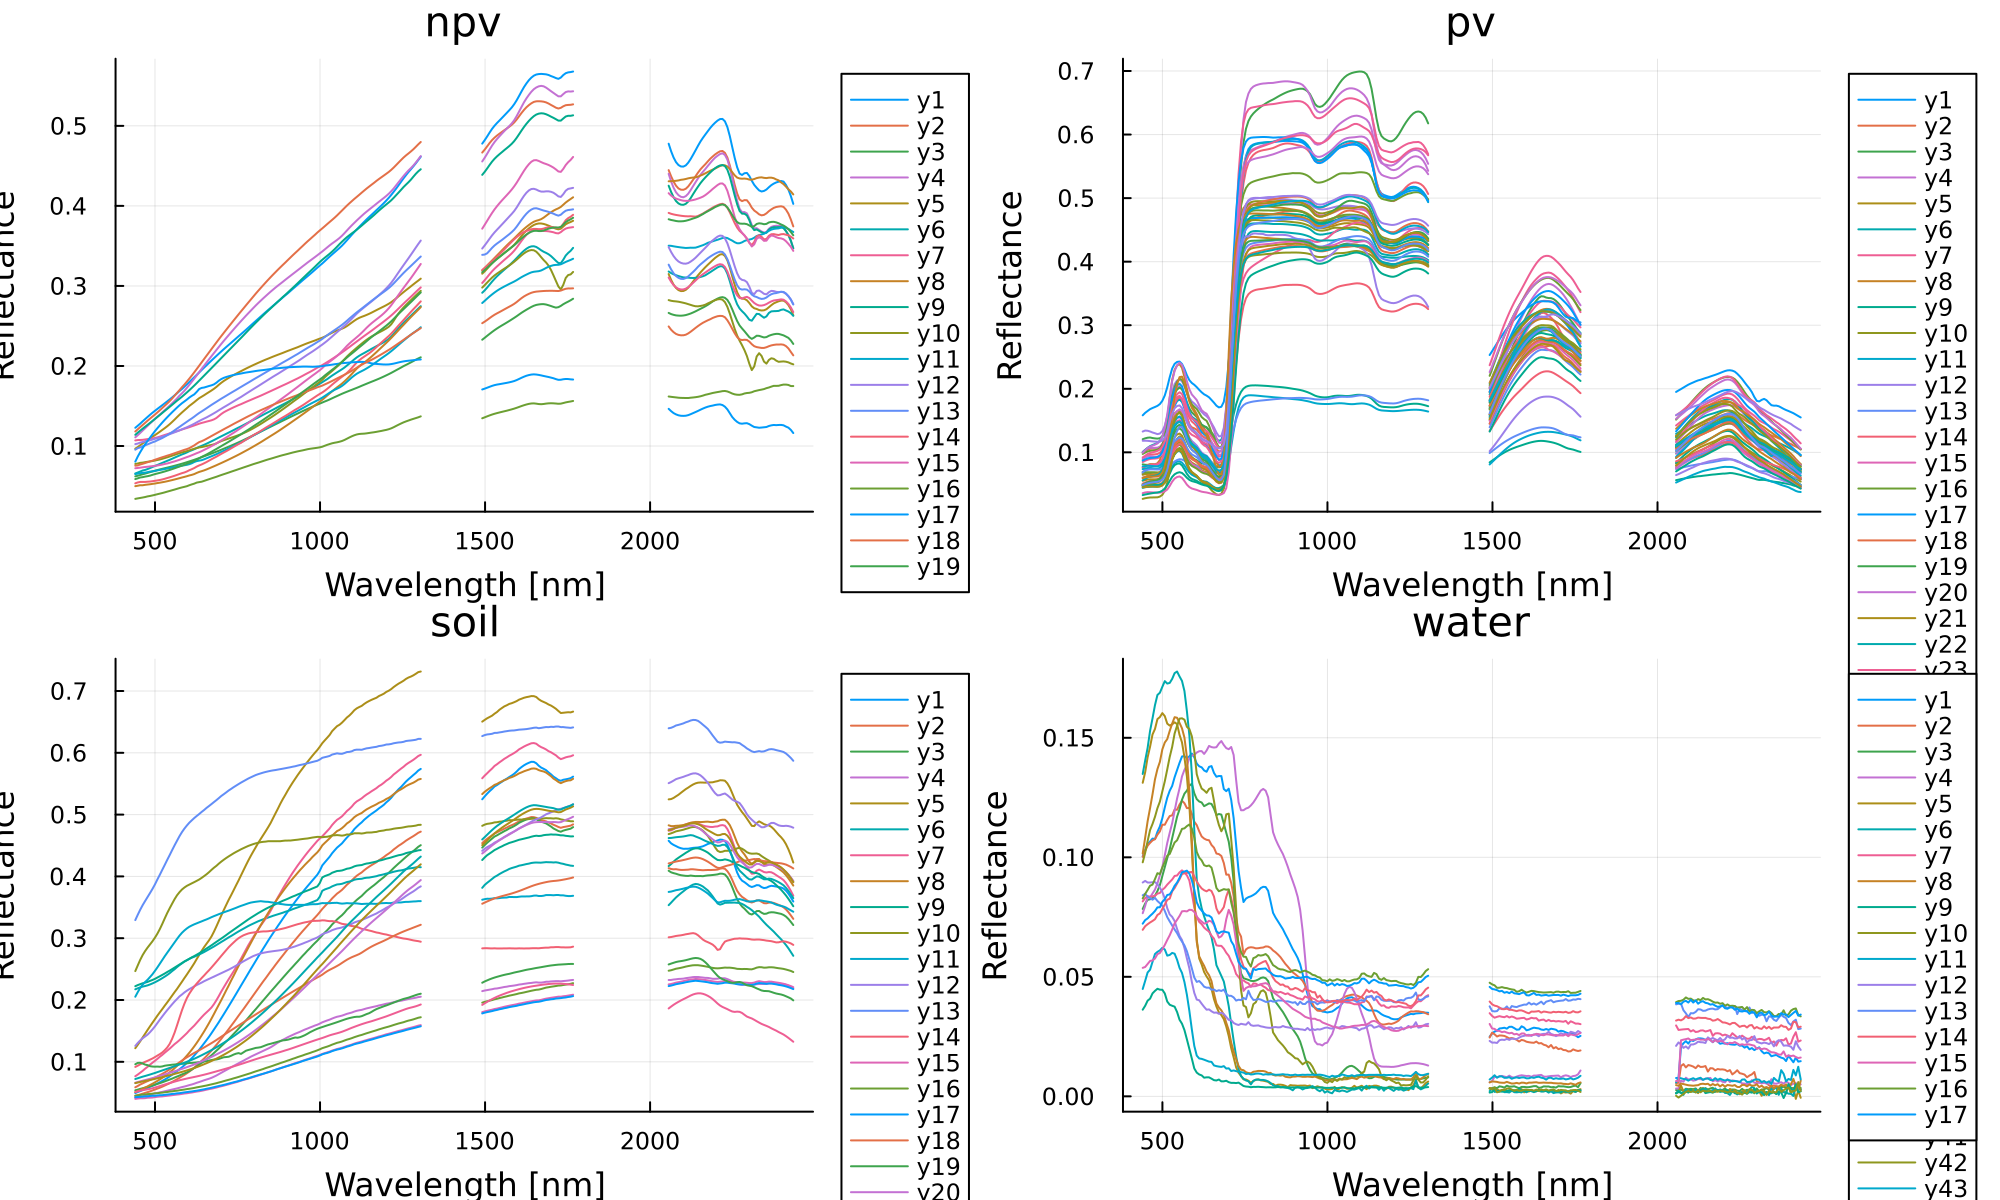

In [270]:
plot_endmembers_individually(merged_library)

In [271]:
el = deepcopy(merged_library)
remove_wavelength_region_inplace!(el, false)

207-element Vector{Bool}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1

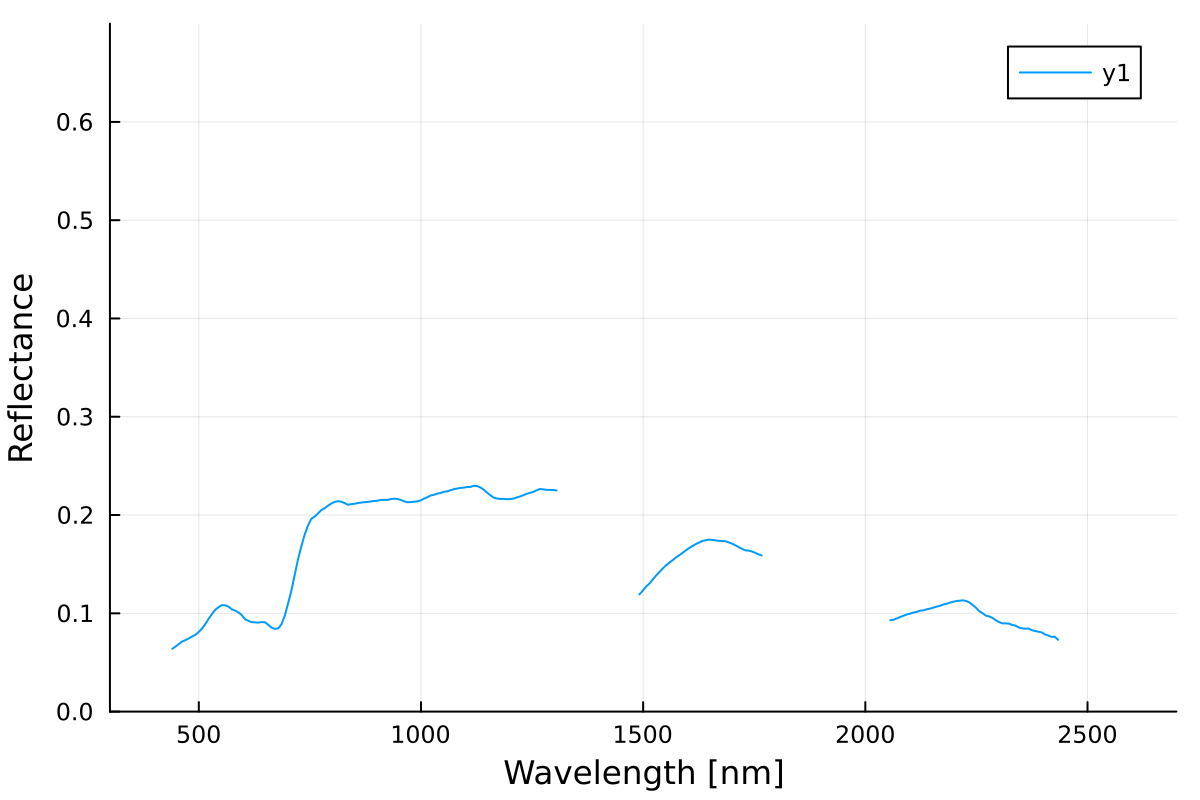

In [272]:
simulated_rfl, tcf, tmf = simulate_pixel(el, 4, "class-even", 13) # 3 endmembers, 13 is random seed? tcf, true class fractions... tmf, true mixing fractions
simulated_rfl = reshape(simulated_rfl, (1, size(simulated_rfl)[1]))

full_rfl = ones(size(merged_library.wavelengths))
full_rfl[merged_library.good_bands] = simulated_rfl[1,:]
plot(merged_library.wavelengths, full_rfl, xlim=[300,2700])

xlabel!("Wavelength [nm]")
ylabel!("Reflectance")
xticks!([500, 1000, 1500, 2000, 2500])
ylims!(0,0.7)
plot!(dpi=200)
plot!()

In [296]:
# MESMA
n_mc = 25 # number of monte carlo iterations
mode = "sma-best" 
num_endmembers=[30] 
normalization="500"
optimization="bvls"

max_combinations=100 # number of endmember combinations?
combination_type="class-even"

merged_library = el

class_idx = prepare_combinations(merged_library, combination_type)
options = prepare_options(merged_library, combination_type, num_endmembers, class_idx)


mr, mv, cfr, cfv = unmix_pixel(merged_library, simulated_rfl, nothing, class_idx, 									options, mode, n_mc, 
            num_endmembers, normalization, optimization, max_combinations, combination_type);

In [297]:
num_instances = 100
mixture_results = zeros(num_instances, size(mr)[1])
comp_frac_results = zeros(num_instances, size(cfr)[1])
simulated_mixtures = zeros(num_instances, size(tmf)[1])

start_time = time()
for idx in 1:num_instances
    simulated_rfl, tcf, tmf = simulate_pixel(el, 4, "class-even", idx)
    simulated_rfl = reshape(simulated_rfl, (1, size(simulated_rfl)[1]))

    mr, mv, cfr, cfv = unmix_pixel(merged_library, simulated_rfl, nothing, class_idx, 
    							   options, mode, n_mc, num_endmembers, normalization, 								   optimization, max_combinations, combination_type)

    mixture_results[idx,:] = mr
    comp_frac_results[idx,:] = cfr
    simulated_mixtures[idx,:] = tmf	
    
end

println(num_instances / (time() - start_time))

28.84984605932719


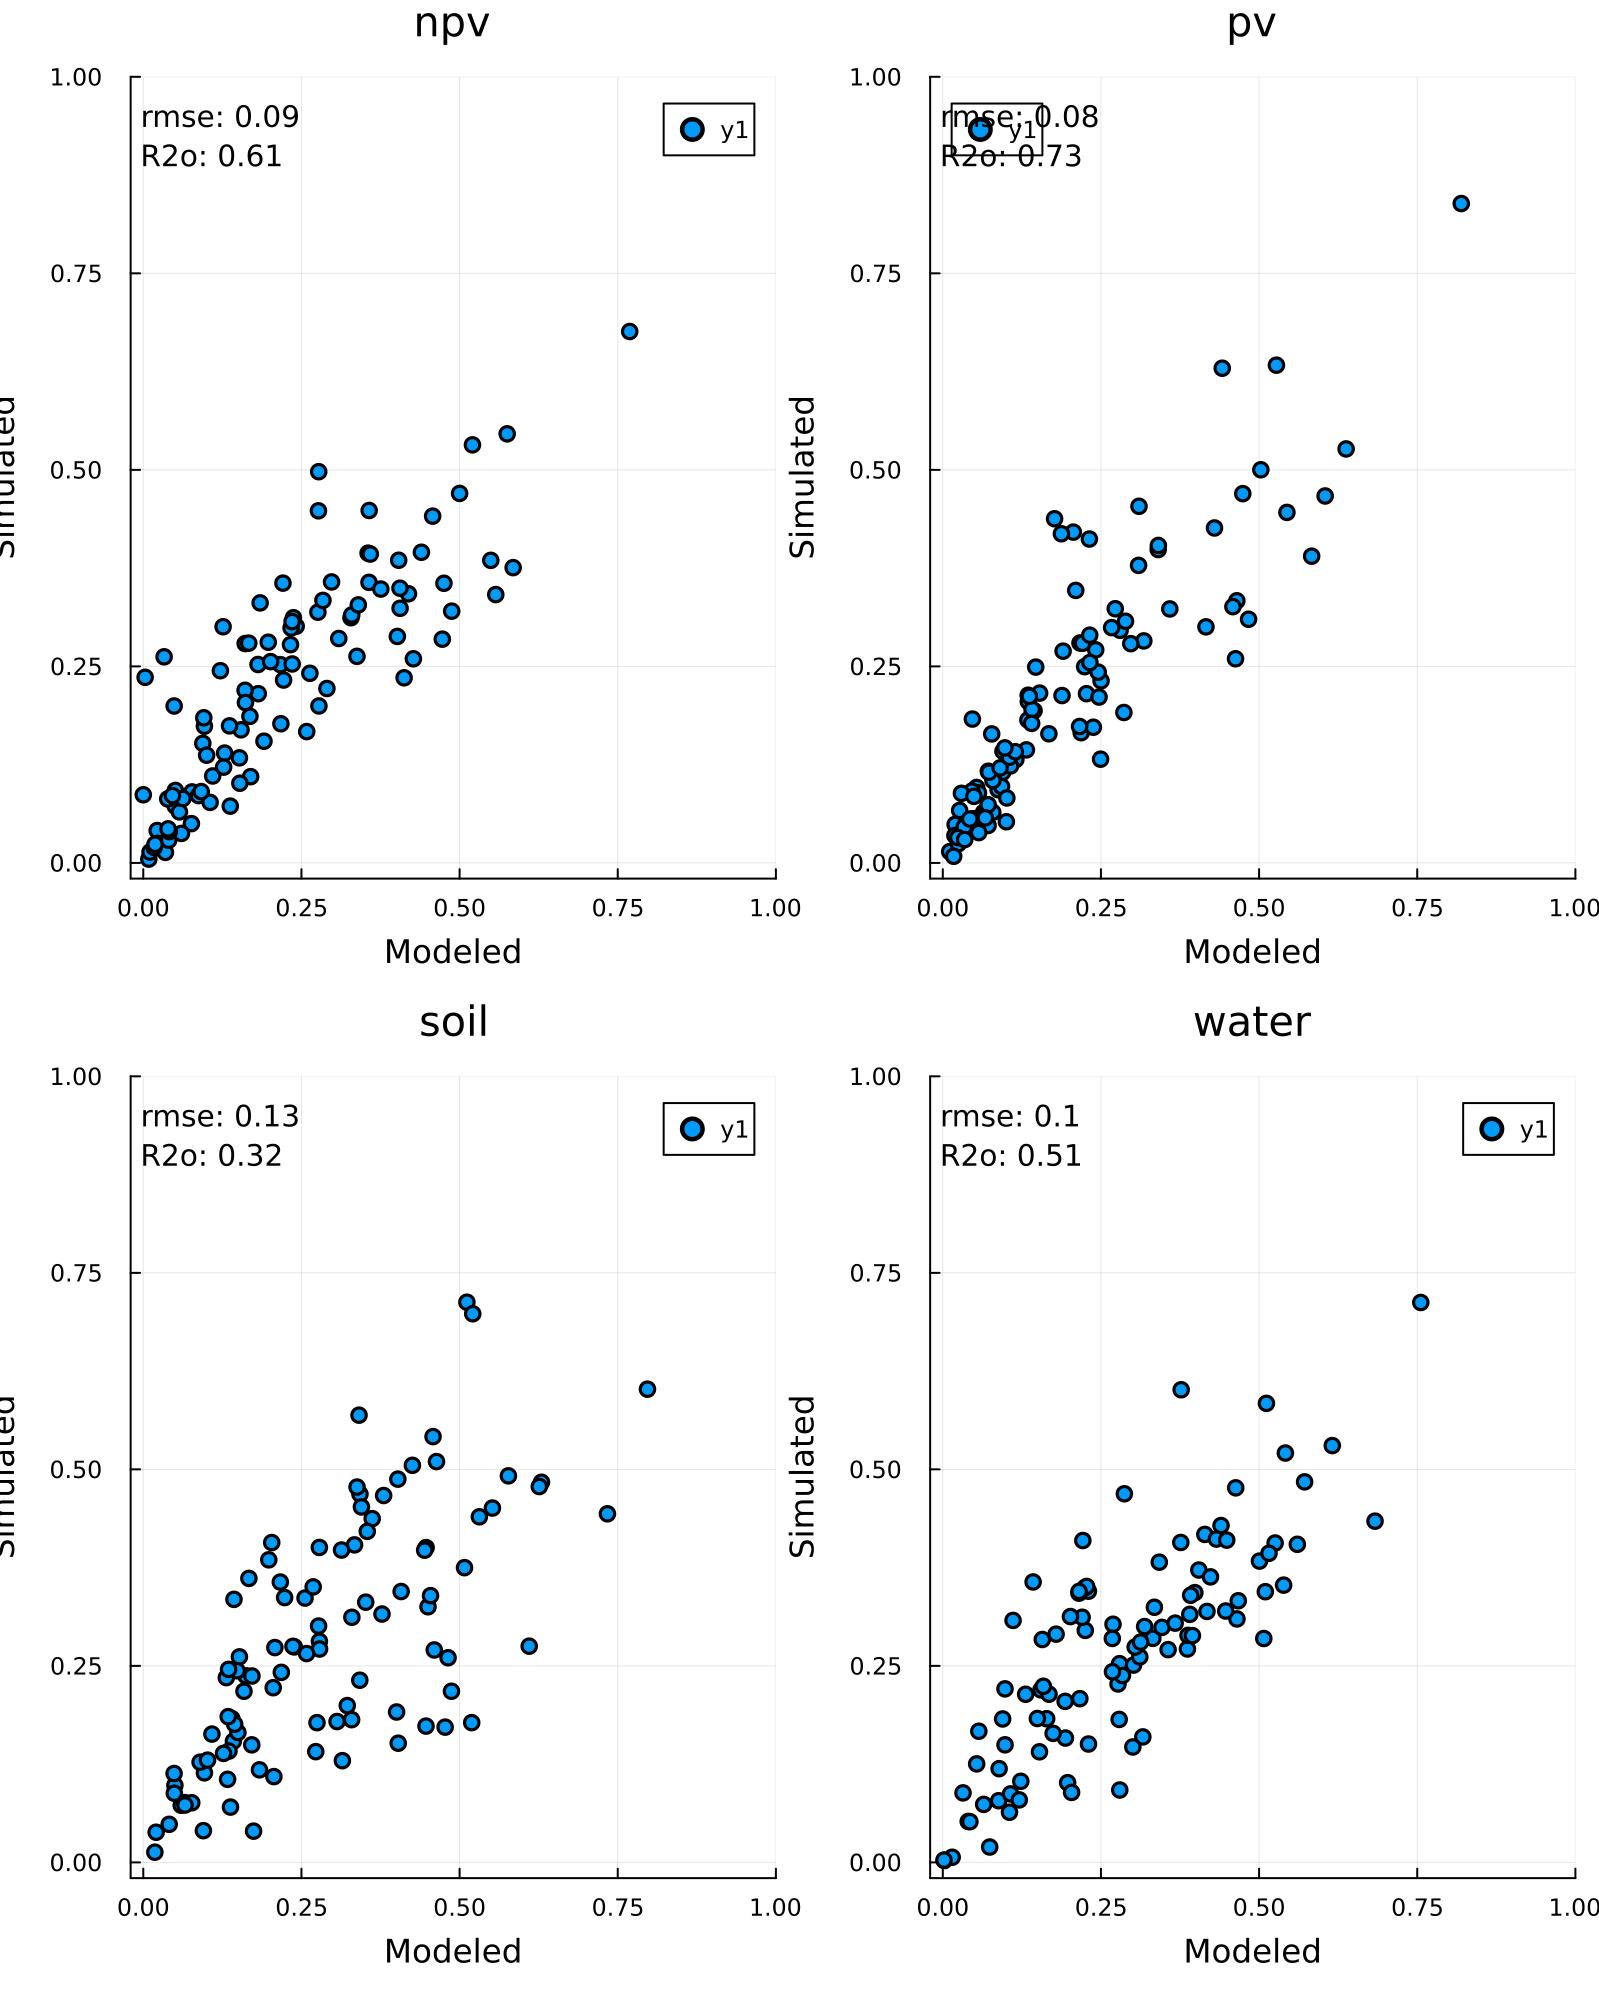

In [298]:
plots = []
for _u in 1:(size(mr)[1] - 1)
    p = plot(mixture_results[:,_u], simulated_mixtures[:,_u], seriestype = :scatter, title=el.class_valid_keys[_u], xlabel="Modeled", ylabel="Simulated")
    r2 = round(1 - sum( (simulated_mixtures[:,_u] - mixture_results[:,_u]).^2 ) /  sum( (simulated_mixtures[:,_u] .- mean(simulated_mixtures[:,_u])).^2 ),digits=2)
    rmse = round(sqrt(mean((simulated_mixtures[:,_u] - mixture_results[:,_u]).^2)),digits=2)
    annotate!(0,0.9,text("R2o: " * string(r2),:left, 10))
    annotate!(0,0.95,text("rmse: " * string(rmse),:left, 10))
    xlims!(-0.02,1)
    ylims!(-0.02,1)
    push!(plots, p)
end
plot(plots...,size=(800,1000),dpi=200)